In [27]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [29]:
sigles = 'A','Ant','B', 'BR', 'C','D', 'D2','E', 'F', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'

In [30]:
from lxml import etree
from re import sub #re — Regular expression operations #
import xml.etree.ElementTree as ET
import string


NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')

def extract_lines(xml_file, expan = True, punct = True, lower = True): #added a 'flag' to the extraction function --> if... else
    lines = {}
    tree = etree.parse(xml_file)
    
    
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False)
        
    for element in tree.iterfind('.//'+"{"+ NSMAP["MVN"]+ "}"+'l'): #add namespace because otherwise it won't find the element gap
        if(element.find('.//'+"{"+ NSMAP["MVN"]+ "}"+'gap')) is not None:
            element.getparent().remove(element)
            
    chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
             'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 
             'u', 'v', 'w', 'x', 'y', 'z'}
            
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" 
    #this will be the key in the dictionary of lines {}
    k = '' 
    for action, node in context:
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 
            
        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn
        
        if 'n' in node.attrib and tag_only == "l":                
            k = title + '-' + node.attrib['n'] #for example 001, 002, 003...
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 

        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
            
            #if a special glyph is present, encode it accordingly
            if tag_only == 'g':

                if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                    text += u'\u0304'

                elif node.attrib['ref'] == '#apomod': # ʼ
                    text += u'\u02bc'

                elif node.attrib['ref'] == '#usmod': # ꝰ
                    text += u'\ua770'

                elif node.attrib['ref'] == '#condes': # ꝯ
                    text += u'\ua76f'

                elif node.attrib['ref'] == '#para': # ¶
                    text += u'\xb6'

                elif node.attrib['ref'] == '#etfin': # ꝫ
                    text += u'\ua76b'

                elif node.attrib['ref'] == '#pbardes': # ꝑ
                    text += u'\ua751'

                elif node.attrib['ref'] == '#pbardes': # ꝕ
                    text += u'\ua755'

                elif node.attrib['ref'] == '#pflour': # ꝓ
                    text += u'\ua753'

                else:
                    node.attrib['ref']
                    text += str(node.attrib['ref']) # get the actual ref if there still are any left

            #encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            #encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            #encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            #if there is still a node with text in it
            elif (node.text):
                text += node.text        

        #after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                if not punct:
                    text = text.translate(str.maketrans('', '', string.punctuation)) #the value of the keys k is the text 
                if lower: 
                    text = text.lower()
                   
                    text = text[::-1]
                  
                lines[k] = text #the value of the keys k is the text 
                text = ''                    
    lines = {k:v for k, v in lines.items() if v.strip()} #if a line with a gap is removed, remove empty key       
    
    return lines

# nog lowercasen (flag) en interpunctie weghalen
d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = True, punct = True, lower = True)
#print(d)

In [31]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = True, punct = False, lower = True)
#print(mss)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


In [32]:
print(mss.keys())

dict_keys(['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'])


In [33]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [ ]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        #print('=================')
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry) 
        #print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))
        

 48%|██████████████████████████████████████▍                                          | 57/120 [07:25<04:55,  4.69s/it]

In [ ]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(40)
mismatches

In [13]:
rolling_window

NameError: name 'rolling_window' is not defined

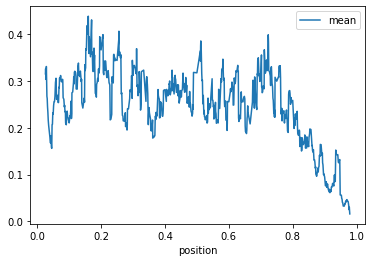

In [22]:
#rolling_q25 = mismatches.groupby('position')['mismatch'].quantile(.25).rolling(window=100).mean()
#rolling_q75 = mismatches.groupby('position')['mismatch'].quantile(.75).rolling(window=100).mean()
w = 10
rolling_window = mismatches.groupby('position')['mismatch'].mean().rolling(window=w).mean()
rolling_std = mismatches.groupby('position')['mismatch'].std().rolling(window=w).mean()
rolling_minus_std = rolling_window - rolling_std / 3
rolling_plus_std = rolling_window + rolling_std / 3
ax = rolling_window.plot(label="mean")
#rolling_q25.plot(label='q25', ax=ax)
#rolling_q75.plot(label='q75', ax=ax)
#rolling_minus_std.plot(label='-std', ax=ax)
#rolling_plus_std.plot(label='+std', ax=ax)
#ax.fill_between(rolling_window.index, rolling_q25, rolling_q75, color='lightgrey')
plt.legend()
rolling_window.shape
plt.savefig('figure3.png', dpi=300)

In [26]:
#checken of de resultaten statistisch significant zijn en dat is zo!
mismatches_end = mismatches[mismatches['position'] > .75]
mismatches_beginning = mismatches[mismatches['position'] <= .75]
from scipy.stats import mannwhitneyu
mannwhitneyu(mismatches_end['mismatch'], mismatches_beginning['mismatch'], alternative='less')

MannwhitneyuResult(statistic=118463320486.5, pvalue=0.0)

## Clustermap

In [ ]:
sigles = sorted(mss.keys())

In [ ]:
df_clust = np.zeros((len(sigles), len(sigles)))
print(df_clust.shape)

In [ ]:
for s1, s2 in combinations(sigles, 2):
    print(s1, s2)
    d = mismatches[(mismatches['ms1'] == s1) & (mismatches['ms2'] == s2)]['mismatch'].mean()
    df_clust[sigles.index(s1), sigles.index(s2)] = d
    df_clust[sigles.index(s2), sigles.index(s1)] = d
df_clust

In [ ]:
df_clust = pd.DataFrame(df_clust, columns=sigles, index=sigles)
df_clust

In [ ]:
import seaborn as sns
sns.clustermap(df_clust);

## Now create bins for positions in verse line

#### bins = 25 # how many bins?

edges = np.linspace(mismatches.position.min(), mismatches.position.max(), bins+1).astype(float).round(2)

labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
mismatches['position_binned'] = pd.cut(mismatches.position, bins=bins, labels=labels)
mismatches['combo'] = mismatches["ms1"]+'-'+mismatches["ms2"]

mismatches

In [50]:
df_binned = mismatches.groupby(['position_binned', 'combo'])['mismatch'].sum().reset_index()
df_binned

,position_binned,combo,mismatch
0,"(0.0, 0.04]",A-C,444
1,"(0.04, 0.08]",A-C,263
2,"(0.08, 0.12]",A-C,308
3,"(0.12, 0.16]",A-C,315
4,"(0.16, 0.2]",A-C,313
5,"(0.2, 0.24]",A-C,322
6,"(0.24, 0.27]",A-C,265
7,"(0.27, 0.31]",A-C,269
8,"(0.31, 0.35]",A-C,277
9,"(0.35, 0.39]",A-C,285


In [51]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import seaborn as sns
import pandas as pd # for data analysis
import numpy as np # for numeric calculation
import matplotlib.pyplot as plt # for data visualization
from matplotlib import pyplot as plt

result_binned = df_binned.pivot(index='combo', columns='position_binned', values='mismatch')
fig, ax = plt.subplots(figsize=(16,10)

sns.heatmap(result_binned, fmt="g", cmap='viridis', linewidths=.5) #annot=True
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-078ca063188d>, line 10)